In [1]:
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

device = "cuda"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+)
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)

# Load and preprocess example images (replace with your own image paths)
image_names = ["data/test_data/back_right_3_rgb.png", "data/test_data/front_left_3_rgb.png", "data/test_data/front_right_3_rgb.png", "data/test_data/robot_3_rgb.png"]
images = load_and_preprocess_images(image_names).to(device)

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        # Predict attributes including cameras, depth maps, and point maps.
        predictions = model(images)

model.safetensors:   0%|          | 0.00/5.03G [00:00<?, ?B/s]

In [3]:
predictions.keys()

dict_keys(['pose_enc', 'depth', 'depth_conf', 'world_points', 'world_points_conf', 'images'])

In [2]:
model = VGGT()
_URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))

Downloading: "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt" to /home/danny/.cache/torch/hub/checkpoints/model.pt
100%|██████████| 4.68G/4.68G [00:44<00:00, 114MB/s] 


<All keys matched successfully>

In [ ]:
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        images = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images)

    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]
    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])

    # Predict Depth Maps
    depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    # Predict Point Maps
    point_map, point_conf = model.point_head(aggregated_tokens_list, images, ps_idx)

    # Construct 3D Points from Depth Maps and Cameras
    # which usually leads to more accurate 3D points than point map branch
    point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0),
                                                                extrinsic.squeeze(0),
                                                                intrinsic.squeeze(0))

    # Predict Tracks
    # choose your own points to track, with shape (N, 2) for one scene
    query_points = torch.FloatTensor([[100.0, 200.0],
                                        [60.72, 259.94]]).to(device)
    track_list, vis_score, conf_score = model.track_head(aggregated_tokens_list, images, ps_idx, query_points=query_points[None])

Instructions:
- Left click on any point in the image to select it
- Points will be numbered and colored uniquely
- Click 'Save' to save points to points.json and image to annotated.png
- Click 'Clear' to remove all points
- Close the window when finished


/home/danny/repos/vggt/get_tracking_points.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


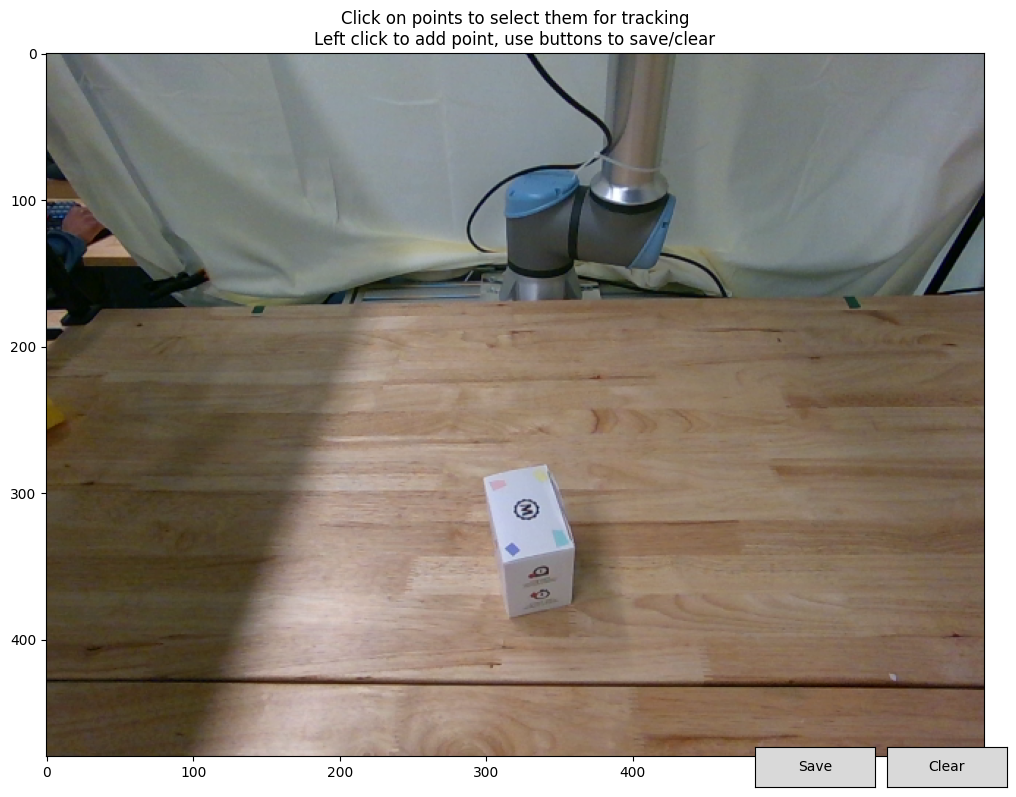

[]

In [4]:
from get_tracking_points import select_tracking_points

input_path = "data/test_data/front_right_3_rgb.png"
select_tracking_points(input_path)